# Annotation Processor for Kaggle Data

In [50]:
import json
import copy
from pathlib import Path
import cv2

In [51]:
# Create a new dictionary to hold the merged dataset
combined_coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "fractured"}],  # Only binary class label
}

# Function to update category ids in annotations to 0 (binary fractured label)
def update_annotations(annotations, image_id_offset, annotation_id_offset):
    updated_annotations = copy.deepcopy(annotations)
    for annotation in updated_annotations:
        annotation["category_id"] = 1  # Set category to binary class "fractured"
        annotation["id"] += annotation_id_offset
        annotation["image_id"] += image_id_offset
    return updated_annotations

# Function to update the image paths for each dataset
def update_image_paths(images, image_id_offset):
    updated_images = copy.deepcopy(images)
    for image in updated_images:
        image["file_name"] = image['file_name'] # Update file path
        image["id"] += image_id_offset  # Update image ID to avoid conflicts
    return updated_images

def add_dummy_annotations(coco_data):
    image_ids_with_annotations = {ann['image_id'] for ann in coco_data['annotations']}
    all_image_ids = {img['id'] for img in coco_data['images']}
    image_ids_without_annotations = all_image_ids - image_ids_with_annotations
    
    # Create dummy annotations for those images (background, i.e., no object)
    dummy_category_id = 0  # assuming "0" means background or no class
    annotation_id_offset = len(coco_data['annotations'])

    for i, image_id in enumerate(image_ids_without_annotations):
        dummy_annotation = {
            'id': annotation_id_offset + i,
            'image_id': image_id,
            'category_id': dummy_category_id,
            'bbox': [0, 0, 0, 0],  # no object, so an empty bbox
            'area': 0,
            'iscrowd': 0
        }
        coco_data['annotations'].append(dummy_annotation)
    coco_data['categories'].append({"id": 0, "name": "No fracture"})
    return coco_data
    

In [58]:
# Load the two COCO annotation files
with open('./data/bone_fracture.v2-release.coco/valid/_annotations.coco.json', 'r') as f:
    coco_file = json.load(f)

# with open('./data/annotations/COCO_fracture_masks.json', 'r') as f:
#     coco_fracAtlas = json.load(f)


# Create a new dictionary to hold the merged dataset
image_id_offset = len(combined_coco["images"])
annotation_id_offset = len(combined_coco["annotations"])
combined_coco["images"].extend(update_image_paths(coco_file["images"], image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_file["annotations"], image_id_offset, annotation_id_offset))
len(combined_coco['annotations']), len(combined_coco['images'])

(3911, 5323)

In [59]:
non_fracAtlas_image_path = './data/kaggle/not_fractured/'
image_id_offset = len(combined_coco["images"])

non_fractured_images = []
for i, image_path in enumerate(Path(non_fracAtlas_image_path).glob("*.jpg")):
    image = cv2.imread('./' + str(image_path))
    image_info = {
        "id": image_id_offset + i,
        "file_name": f"{non_fracAtlas_image_path}{image_path.name}",
        "width": image.shape[1],
        "height": image.shape[0],
    }
    non_fractured_images.append(image_info)

combined_coco["images"].extend(non_fractured_images)

add_dummy_annotations(combined_coco)

len(combined_coco['annotations']), len(combined_coco['images'])

(9386, 8689)

In [60]:
# Save the combined dataset as a new JSON file
with open('./data/kaggle/annotations/combined_annotations_coco.json', 'w') as f:
    json.dump(combined_coco, f)
print("Combined COCO dataset with updated image paths created successfully!")

Combined COCO dataset with updated image paths created successfully!


In [46]:
image_path = []
image_class = []
for image in coco_big['images']:
    image_id = image['id']
    for annotation in coco_big['annotations']:
        if annotation['image_id'] == image_id:
            image_path.append(coco_big['images'][image_id]['file_name'])
            image_class.append(annotation['category_id'])
            break

In [47]:
import pandas as pd 
annotation_df = pd.DataFrame({
    'image_dir': image_path,
    'fractured': image_class
})

In [48]:
annotation_df.to_csv('./data/BoneFracture_localization.v2i.coco/annotation.csv', index=False)

In [49]:
annotation_df.loc[annotation_df['fractured'] == 1]

,image_dir,fractured
5,IMG0002518_jpg.rf.d0147fdaa3bd51a1cbbd22c962e3...,1
6,image1_1150_png_jpg.rf.d006082f0fb37511ebc5c34...,1
7,image1_3795_png_jpg.rf.cff4005287cd019c323c518...,1
10,image2_69_png_jpg.rf.d03f23ee57a2955b954ffbedb...,1
17,IMG0002518_jpg.rf.d05544ecb4ac5e9d9ff24055a3f6...,1
...,...,...
18233,IMG0003294_jpg.rf.44c98914ab883e0e9ab933b4ab18...,1
18239,IMG0002370_jpg.rf.4509017b974d55002ddbb236be2f...,1
18241,image1_3541_png_jpg.rf.44dc92e144853c990cab2aa...,1
18244,IMG0002265_jpg.rf.4515ceb8923343b9eb11728f8459...,1


# Tensorboard

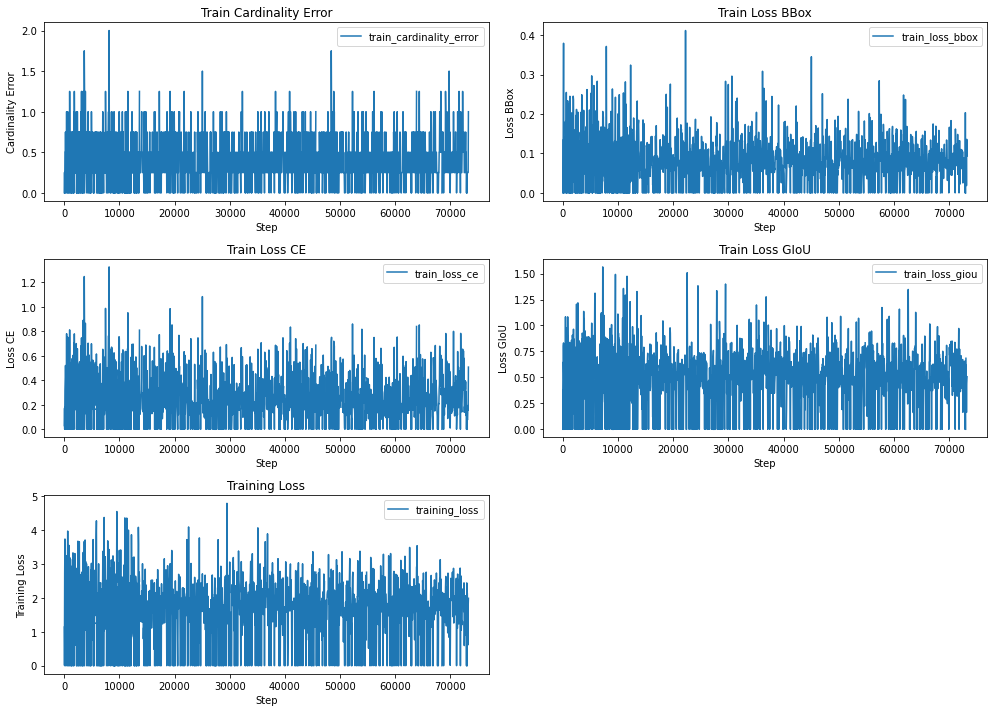

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = './lightning_logs/version_16/metrics.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)
df2 = pd.read_csv('./lightning_logs/version_15/metrics.csv')
df = pd.concat((df2, df))

# Plotting
plt.figure(figsize=(14, 10))

# Plot train_cardinality_error
plt.subplot(3, 2, 1)
plt.plot(df['step'], df['train_cardinality_error'], label='train_cardinality_error')
plt.xlabel('Step')
plt.ylabel('Cardinality Error')
plt.title('Train Cardinality Error')
plt.legend()

# Plot train_loss_bbox
plt.subplot(3, 2, 2)
plt.plot(df['step'], df['train_loss_bbox'], label='train_loss_bbox')
plt.xlabel('Step')
plt.ylabel('Loss BBox')
plt.title('Train Loss BBox')
plt.legend()

# Plot train_loss_ce
plt.subplot(3, 2, 3)
plt.plot(df['step'], df['train_loss_ce'], label='train_loss_ce')
plt.xlabel('Step')
plt.ylabel('Loss CE')
plt.title('Train Loss CE')
plt.legend()

# Plot train_loss_giou
plt.subplot(3, 2, 4)
plt.plot(df['step'], df['train_loss_giou'], label='train_loss_giou')
plt.xlabel('Step')
plt.ylabel('Loss GIoU')
plt.title('Train Loss GIoU')
plt.legend()

# Plot training_loss
plt.subplot(3, 2, 5)
plt.plot(df['step'], df['training_loss'], label='training_loss')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


# MURA

In [29]:
import glob
image_paths = []
image_class = []
mura_label_df = pd.read_csv('./data/MURA-v1.1/train_labeled_studies.csv', header= None)
for folder_path, label in zip(mura_label_df.values[:,0], mura_label_df.values[:,1]):
    file_names = glob.glob(f"./data/{folder_path}/*")
    image_paths.extend(file_names)
    image_class.extend([label]*len(file_names))
    
train_df = pd.DataFrame({
    'image_dir': image_paths,
    'fractured': image_class
})

image_paths = []
image_class = []
mura_label_df = pd.read_csv('./data/MURA-v1.1/valid_labeled_studies.csv', header= None)
for folder_path, label in zip(mura_label_df.values[:,0], mura_label_df.values[:,1]):
    file_names = glob.glob(f"./data/{folder_path}/*")
    image_paths.extend(file_names)
    image_class.extend([label]*len(file_names))
    
valid_df = pd.DataFrame({
    'image_dir': image_paths,
    'fractured': image_class
})

In [31]:
train_df.shape, valid_df.shape

((36806, 2), (3197, 2))

In [32]:
train_df.to_csv('./data/MURA-v1.1/train_labels.csv', index= False)
valid_df.to_csv('./data/MURA-v1.1/valid_labels.csv', index= False)

In [33]:
train_df.describe()

,fractured
count,36806.000000
mean,0.404092
std,0.490722
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000
